In [1]:
import pandas as pd
import h5py
import seaborn as sns
import scipy.io
import pickle
import numpy as np
import statsmodels.stats.multitest as multitest
import scipy.stats as stats
import matplotlib.pyplot as plt 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import ScalarFormatter
from sklearn import preprocessing
from sklearn import metrics
def get_groups_and_return_genes_and_species(taxa_level):

    #Import packages
    import pandas as pd
    import numpy as np 


    #Read in used files 
    ortho_groups_to_genes = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/odb10v1_OG2genes.tab',sep = '\t',names = 
        ['Group ID','Gene ID'])
    ortho_groups_to_taxa = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/odb10v1_OGs.tab', sep = '\t',names = 
        ['Group ID','taxa_ID','Group Name'])
    ortho_genes_to_species = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/odb10v1_genes.tab', sep = '\t',names = 
        ['Gene ID','species_ID','Protein seq','synonyms','Uniprot','Ensembl','NCBI','Description'])
    indexed_ortho_genes = ortho_genes_to_species.set_index('Gene ID')
    coconet_plants = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/tax_report.txt', sep = '\t')
    coconet_plants.drop(['code','|','|.1','|.2','preferred name'],axis = 1,inplace=True)

    # Get the groups 
    ortho_groups_built_on_taxa_lvl = ortho_groups_to_taxa.loc[ortho_groups_to_taxa['taxa_ID'] == taxa_level ]
    ortho_list_taxa_lvl = ortho_groups_built_on_taxa_lvl['Group ID']
    ortho_genes_in_taxa_groups = ortho_groups_to_genes.loc[ortho_groups_to_genes['Group ID'].isin(ortho_list_taxa_lvl.to_list())]

    #Drop Duplicates 
    ortho_genes_in_taxa_groups.drop_duplicates(subset ='Gene ID',inplace=True)
    #Clean Species ID
    ortho_genes_in_taxa_groups['Species ID'] = ortho_genes_in_taxa_groups['Gene ID'].str.partition('_')[0]

    #Drop Species not in CococoNet 
    ortho_genes_in_taxa_cocoplants = ortho_genes_in_taxa_groups.loc[ortho_genes_in_taxa_groups['Species ID'].isin(list(map(str,
        coconet_plants['taxid'].to_list())))]
    #Get Gene and Common Name mapping    
    ortho_genes_in_taxa_cocoplants.merge(right =ortho_genes_to_species[['Gene ID','Uniprot','Ensembl','NCBI']], on = 'Gene ID',how = 'left')   
    coconet_plants.columns =['Common Name', 'Species ID']
    coconet_typed = coconet_plants.astype({'Species ID':'str'})
    ortho_genes_in_taxa_cocoplants.merge(right = coconet_typed, on = 'Species ID',how = 'left' )  

    return ortho_genes_in_taxa_cocoplants

def read_cococonet(file_location):
    import h5py
    net = h5py.File(file_location,'r')
    agg_dataset = net['agg'] 
    row_dataset = net['row']
    col_dataset = net['col']
    row_gene_list = []
    for gene in row_dataset:
        row_gene_list.append(gene.decode('UTF-8'))
    col_gene_list = []
    for gene in col_dataset: 
        col_gene_list.append(gene.decode('UTF-8'))
    net_df = pd.DataFrame(data = agg_dataset[:,:], index = row_gene_list, columns = col_gene_list)
    net.close()
    return net_df


In [2]:
eudicot_groups = get_groups_and_return_genes_and_species(71240)
arabi_groups = eudicot_groups.loc[eudicot_groups['Species ID'] == '3702']


/home/passala/miniconda3/envs/py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-1-6a3afe972ff6>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ortho_genes_in_taxa_groups.drop_duplicates(subset ='Gene ID',inplace=True)
<ipython-input-1-6a3afe972ff6>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ortho_genes_in_taxa_groups['Species ID'] = ortho_genes_in_taxa_groups['Gen

In [2]:
test_making_new_panda = pd.DataFrame(index = ['20','30'],columns =['Alpha','Beta'])
test_making_new_panda

Alpha Beta
20   NaN  NaN
30   NaN  NaN

In [3]:
arabi_groups.value_counts('Group ID').sort_values(ascending = False)

Group ID
20902at71240     126
96511at71240      87
139904at71240     86
92729at71240      74
84127at71240      49
                ... 
102077at71240      1
94424at71240       1
9443at71240        1
94443at71240       1
100004at71240      1
Length: 16076, dtype: int64

In [4]:
list_of_groups = arabi_groups.value_counts('Group ID').sort_values(ascending = False)
index_by_group = arabi_groups.set_index(keys = 'Group ID')
trimmed_arabi_groups = index_by_group[list_of_groups<3]
trimmed_arabi_groups = trimmed_arabi_groups[list_of_groups>1]
trimmed_arabi_groups.reset_index(inplace = True)
trimmed_arabi_groups

<ipython-input-4-a099b19913b6>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trimmed_arabi_groups = index_by_group[list_of_groups<3]
<ipython-input-4-a099b19913b6>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trimmed_arabi_groups = trimmed_arabi_groups[list_of_groups>1]


Group ID        Gene ID Species ID
0     100116at71240  3702_0:002b01       3702
1     100116at71240  3702_0:0041f8       3702
2     100120at71240  3702_0:0050e2       3702
3     100120at71240  3702_0:0050fc       3702
4     100170at71240  3702_0:00569c       3702
...             ...            ...        ...
6931   99915at71240  3702_0:002d40       3702
6932   99980at71240  3702_0:00060f       3702
6933   99980at71240  3702_0:002475       3702
6934   99991at71240  3702_0:003f4d       3702
6935   99991at71240  3702_0:0066a9       3702

[6936 rows x 3 columns]

In [5]:
# Skipped as time saver, see below cell 
# ortho_genes_to_species = pd.read_csv('/home/passala/Gene_duplication_project/Data_from_others/odb10v1_genes.tab', sep = '\t',names = ['Gene ID','species ID','Protein seq',         'synonyms','Uniprot','Ensembl','NCBI','Description'])
# ortho_genes_to_species['species ID'] = ortho_genes_to_species['Gene ID'].str.partition('_')[0]
# arab_ortho_genes = ortho_genes_to_species.loc[ortho_genes_to_species['species ID'] == '3702']
# arab_ortho_genes.reset_index(inplace = True,drop = True)
# arab_ortho_genes.to_csv('/home/passala/Gene_duplication_project/Generated_tables/Time Savers/arab_ortho_genes.csv',index = False)

In [6]:
arab_ortho_genes = pd.read_csv('/home/passala/Gene_duplication_project/Generated_tables/Time_Savers/arab_ortho_genes.csv')
arab_ortho_genes


Gene ID  species ID  Protein seq   synonyms     Uniprot  \
0      3702_0:000000        3702  NP_564157.1    EMB2204      Q9LM50   
1      3702_0:000001        3702  NP_565238.1  AT1G80440      Q9M8L2   
2      3702_0:000002        3702  NP_176192.1      PP2A1      Q07099   
3      3702_0:000003        3702  NP_173549.1       WAK2      Q9LMP1   
4      3702_0:000004        3702  NP_174748.1  AT1G35150      Q9C6E6   
...              ...         ...          ...        ...         ...   
27446  3702_0:006b36        3702  NP_051054.1       psbD  A0A1B1W4U0   
27447  3702_0:006b37        3702  NP_051115.1       ndhH  A0A1B1W502   
27448  3702_0:006b38        3702  NP_051061.1       rps4  A0A1B1W4U6   
27449  3702_0:006b39        3702  NP_051039.1       psbA  A0A1B1W4S7   
27450  3702_0:006b3a        3702  NP_051112.1       ndhG  A0A1B1W4Z6   

         Ensembl      NCBI                                        Description  
0      AT1G22090  838814.0                            UPF0725 protein EMB2204  
1      AT1G80440  844383.0               F-box/kelch-repeat protein At1g80440  
2      AT1G59830  842276.0  Serine/threonine-protein phosphatase PP2A-1 ca...  
3      AT1G21270  838723.0                  Wall-associated receptor kinase 2  
4      AT1G35150  840402.0  General transcription factor 2-related zinc fi...  
...          ...       ...                                                ...  
27446  ATCG00270  844775.0                          Photosystem II D2 protein  
27447  ATCG01110  844805.0  NAD(P)H-quinone oxidoreductase subunit H, chlo...  
27448  ATCG00380  844765.0            30S ribosomal protein S4, chloroplastic  
27449  ATCG00020  844802.0                          Photosystem II protein D1  
27450  ATCG01080  844739.0  NAD(P)H-quinone oxidoreductase subunit 6, chlo...  

[27451 rows x 8 columns]

In [7]:
#mustard_arabdidopsis_functional_conservation = pd.read_csv('/home/passala/Gene_duplication_project/Networks/N_M_files/mustard_arabidopsis_prio_NM.csv')


In [8]:
mapped_dupes = trimmed_arabi_groups.merge(arab_ortho_genes,on = 'Gene ID',how = 'left')
mapped_dupes.drop(['Protein seq','synonyms','Uniprot','NCBI'],axis = 1, inplace = True)
mapped_dupes.rename(columns = {'Ensembl':'sp2_gene'}, inplace = True)
mapped_dupes.dropna(axis = 'rows',subset = ['sp2_gene'])
mapped_dupes

Group ID        Gene ID Species ID  species ID   sp2_gene  \
0     100116at71240  3702_0:002b01       3702        3702  AT2G17390   
1     100116at71240  3702_0:0041f8       3702        3702  AT4G35450   
2     100120at71240  3702_0:0050e2       3702        3702  AT4G19250   
3     100120at71240  3702_0:0050fc       3702        3702  AT4G19330   
4     100170at71240  3702_0:00569c       3702        3702  AT5G25950   
...             ...            ...        ...         ...        ...   
6931   99915at71240  3702_0:002d40       3702        3702  AT3G59760   
6932   99980at71240  3702_0:00060f       3702        3702  AT1G14720   
6933   99980at71240  3702_0:002475       3702        3702  AT2G01850   
6934   99991at71240  3702_0:003f4d       3702        3702  AT3G04860   
6935   99991at71240  3702_0:0066a9       3702        3702  AT5G28150   

                                            Description  
0           Ankyrin repeat domain-containing protein 2B  
1                   Ankyrin repeat-containing protein 2  
2     Galactose oxidase/kelch repeat superfamily pro...  
3                  F-box/kelch-repeat protein At4g19330  
4                               AslB, putative (DUF239)  
...                                                 ...  
6931                                  Cysteine synthase  
6932          Xyloglucan endotransglucosylase/hydrolase  
6933  Probable xyloglucan endotransglucosylase/hydro...  
6934                                   A0A178V8A5_ARATH  
6935                                 AT5g28150/T24G3_80  

[6936 rows x 6 columns]

In [9]:
arabi_coconet = read_cococonet('/home/passala/Gene_duplication_project/Networks/arabidopsis_prioAggNet.hdf5')
arabi_coconet_ranked= arabi_coconet.rank() # Among the genes that coexpress with column, index is ranked z 
arabi_coconet

AT1G01020  AT1G01030  AT1G01040  AT1G01050  AT1G01060  AT1G01070  \
AT1G01020   1.000000   0.676041   0.885107   0.916603   0.167027   0.625596   
AT1G01030   0.676041   1.000000   0.707718   0.515532   0.420354   0.292083   
AT1G01040   0.885107   0.707718   1.000000   0.836387   0.545101   0.701558   
AT1G01050   0.916603   0.515532   0.836387   1.000000   0.562112   0.726964   
AT1G01060   0.167027   0.420354   0.545101   0.562112   1.000000   0.327202   
...              ...        ...        ...        ...        ...        ...   
ATCG01120   0.287853   0.270118   0.186425   0.213062   0.125488   0.083681   
ATCG01130   0.559907   0.463394   0.219380   0.412583   0.212731   0.077222   
ATCG01180   0.017205   0.083490   0.032348   0.046082   0.061676   0.022381   
ATCG01210   0.011806   0.059014   0.018332   0.029016   0.057518   0.026014   
ATCG01310   0.091015   0.108780   0.057761   0.086736   0.044208   0.028005   

           AT1G01080  AT1G01090  AT1G01100  AT1G01110  ...  ATCG01070  \
AT1G01020   0.801175   0.866369   0.954286   0.715750  ...   0.111731   
AT1G01030   0.687003   0.626281   0.483536   0.570675  ...   0.245167   
AT1G01040   0.656258   0.857046   0.657204   0.650843  ...   0.155183   
AT1G01050   0.837948   0.928252   0.952045   0.640223  ...   0.089440   
AT1G01060   0.242215   0.304953   0.217415   0.077569  ...   0.082518   
...              ...        ...        ...        ...  ...        ...   
ATCG01120   0.364707   0.333718   0.237716   0.149145  ...   0.858389   
ATCG01130   0.625678   0.496059   0.428496   0.226147  ...   0.881835   
ATCG01180   0.090228   0.069825   0.028903   0.015799  ...   0.751869   
ATCG01210   0.062831   0.043944   0.015468   0.018706  ...   0.687306   
ATCG01310   0.205339   0.176358   0.066842   0.050985  ...   0.410096   

           ATCG01080  ATCG01090  ATCG01100  ATCG01110  ATCG01120  ATCG01130  \
AT1G01020   0.193853   0.261697   0.299060   0.321617   0.287853   0.559907   
AT1G01030   0.215414   0.255414   0.306986   0.308402   0.270118   0.463394   
AT1G01040   0.230038   0.149740   0.334558   0.287951   0.186425   0.219380   
AT1G01050   0.177388   0.164935   0.236661   0.251851   0.213062   0.412583   
AT1G01060   0.125455   0.103488   0.187982   0.195059   0.125488   0.212731   
...              ...        ...        ...        ...        ...        ...   
ATCG01120   0.905572   0.926062   0.941864   0.954421   1.000000   0.969018   
ATCG01130   0.936241   0.946935   0.958553   0.960399   0.969018   1.000000   
ATCG01180   0.781811   0.740045   0.745181   0.676666   0.450607   0.467233   
ATCG01210   0.710940   0.676507   0.687223   0.567304   0.357960   0.412343   
ATCG01310   0.466130   0.465530   0.496910   0.453522   0.410586   0.483002   

           ATCG01180  ATCG01210  ATCG01310  
AT1G01020   0.017205   0.011806   0.091015  
AT1G01030   0.083490   0.059014   0.108780  
AT1G01040   0.032348   0.018332   0.057761  
AT1G01050   0.046082   0.029016   0.086736  
AT1G01060   0.061676   0.057518   0.044208  
...              ...        ...        ...  
ATCG01120   0.450607   0.357960   0.410586  
ATCG01130   0.467233   0.412343   0.483002  
ATCG01180   1.000000   0.999090   0.579657  
ATCG01210   0.999090   1.000000   0.511263  
ATCG01310   0.579657   0.511263   1.000000  

[20879 rows x 20879 columns]

In [10]:
boolean_dropper = mapped_dupes['sp2_gene'].isin(arabi_coconet.columns.to_list())
mapped_dupes = mapped_dupes[boolean_dropper]
mapped_dupes

Group ID        Gene ID Species ID  species ID   sp2_gene  \
0     100116at71240  3702_0:002b01       3702        3702  AT2G17390   
1     100116at71240  3702_0:0041f8       3702        3702  AT4G35450   
6     100176at71240  3702_0:001e85       3702        3702  AT2G43480   
7     100176at71240  3702_0:006039       3702        3702  AT5G24070   
8     100363at71240  3702_0:00416b       3702        3702  AT3G58970   
...             ...            ...        ...         ...        ...   
6931   99915at71240  3702_0:002d40       3702        3702  AT3G59760   
6932   99980at71240  3702_0:00060f       3702        3702  AT1G14720   
6933   99980at71240  3702_0:002475       3702        3702  AT2G01850   
6934   99991at71240  3702_0:003f4d       3702        3702  AT3G04860   
6935   99991at71240  3702_0:0066a9       3702        3702  AT5G28150   

                                            Description  
0           Ankyrin repeat domain-containing protein 2B  
1                   Ankyrin repeat-containing protein 2  
6                                Probable peroxidase 26  
7                                            Peroxidase  
8                                                MRS2-4  
...                                                 ...  
6931                                  Cysteine synthase  
6932          Xyloglucan endotransglucosylase/hydrolase  
6933  Probable xyloglucan endotransglucosylase/hydro...  
6934                                   A0A178V8A5_ARATH  
6935                                 AT5g28150/T24G3_80  

[5854 rows x 6 columns]

In [11]:
list_of_groups = mapped_dupes.value_counts('Group ID').sort_values(ascending = False)
index_by_group = mapped_dupes.set_index(keys = 'Group ID')

In [12]:
list_of_group_pairs = list_of_groups[list_of_groups<3]
list_of_group_pairs = list_of_group_pairs[list_of_group_pairs>1]
list_of_group_pairs = list_of_group_pairs.index.to_list()
list_of_group_pairs[0:20]

['100116at71240',
 '121706at71240',
 '122930at71240',
 '122964at71240',
 '123140at71240',
 '123219at71240',
 '123281at71240',
 '122498at71240',
 '116584at71240',
 '122460at71240',
 '121421at71240',
 '123836at71240',
 '121554at71240',
 '121573at71240',
 '121593at71240',
 '121620at71240',
 '12169at71240',
 '116636at71240',
 '121941at71240',
 '122347at71240']

In [13]:
group_and_paired_genes = []
for group in list_of_group_pairs:
    filtered_panda = mapped_dupes.loc[mapped_dupes['Group ID'] == group]
    one_row_in_resulting_panda = [group,filtered_panda['sp2_gene'].iloc[0],filtered_panda['sp2_gene'].iloc[1]]
    group_and_paired_genes.append(one_row_in_resulting_panda)
paired_genes_and_group_pd = pd.DataFrame(data = group_and_paired_genes, columns = ['Group ID', 'Gene 1', 'Gene 2'])
paired_genes_and_group_pd


Group ID     Gene 1     Gene 2
0     100116at71240  AT2G17390  AT4G35450
1     121706at71240  AT2G01180  AT3G02600
2     122930at71240  AT1G78700  AT4G18890
3     122964at71240  AT1G20880  AT1G76460
4     123140at71240  AT3G02980  AT5G16800
...             ...        ...        ...
2694   82324at71240  AT1G44130  AT1G77480
2695    8222at71240  AT5G09350  AT5G64070
2696    8234at71240  AT1G52570  AT3G15730
2697    8224at71240  AT1G04700  AT3G24715
2698   82839at71240  AT1G21400  AT5G09300

[2699 rows x 3 columns]

In [14]:
test_panda = mapped_dupes.loc[mapped_dupes['Group ID'] == '34251at71240']
test_panda

Group ID        Gene ID Species ID  species ID   sp2_gene  \
4352  34251at71240  3702_0:000747       3702        3702  AT1G17030   
4353  34251at71240  3702_0:001d17       3702        3702  AT2G47010   

             Description  
4352    A0A178WBQ2_ARATH  
4353  At2g47010/F14M4.16

In [15]:
top_10_genes = np.array([arabi_coconet[c].nlargest(11).index.values for c in arabi_coconet])#using pair list above, cut down top 10 list to relevant genes, probably by adding list as a column in panda and then filtering panda to index of pair list 

In [16]:
top_10_genes_dataframe = pd.DataFrame(data = top_10_genes, index = arabi_coconet.index, columns = ['Zero','One','Two','Three','Four','Five','Six','Seven','Eight','Nine','Ten'])
top_10_genes_dataframe.drop(columns = 'Zero',inplace = True)
top_10_genes_dataframe

One        Two      Three       Four             Five  \
AT1G01020  AT1G30590  AT3G15010  AT3G54480  AT2G48100        AT5G02770   
AT1G01030  AT1G31650  AT3G11170  AT5G50860  AT2G46810        AT5G67260   
AT1G01040  AT4G00060  AT3G54230  AT5G35210  AT1G55325        AT1G73960   
AT1G01050  AT2G42210  AT2G17390  AT5G36230  AT4G02580        AT3G14290   
AT1G01060  AT3G09600  AT2G46830  AT5G64940  AT4G38960        AT3G12320   
...              ...        ...        ...        ...              ...   
ATCG01120  ATCG01130  ATCG01110  ATCG00800  ATCG00740        ATCG01100   
ATCG01130  ATCG00800  ATCG00790  ATCG00740  ATCG00810        ATCG00650   
ATCG01180  ATCG00950  ATCG01210  ATCG00920  ATCG00020        ATCG00490   
ATCG01210  ATCG01180  ATCG00950  ATCG00920  ATCG00490  ENSRNA049495549   
ATCG01310  ATCG00830  ATCG00480  ATCG00950  ATCG00470        ATCG00810   

                 Six            Seven      Eight       Nine        Ten  
AT1G01020  AT3G26920        AT5G66240  AT5G59460  AT5G67610  AT2G45640  
AT1G01030  AT2G13440        AT2G43950  AT2G28540  AT2G45950  AT3G09670  
AT1G01040  AT2G29210        AT4G16310  AT5G22760  AT2G27980  AT1G79350  
AT1G01050  AT5G40810        AT1G09150  AT5G10460  AT5G66510  AT4G06599  
AT1G01060  AT3G54500        AT4G15430  AT2G31380  AT5G15950  AT3G01060  
...              ...              ...        ...        ...        ...  
ATCG01120  ATCG00770        ATCG00650  ATCG01010  ATCG00660  ATCG01090  
ATCG01130  ATCG00780        ATCG00150  ATCG00770  ATCG00040  ATCG00530  
ATCG01180  ATCG00680  ENSRNA049495549  ATCG00350  ATCG00720  ATCG00340  
ATCG01210  ATCG00020        ATCG00680  ATCG00350  ATCG00280  ATCG00340  
ATCG01310  ATCG00780        ATCG01180  ATCG00820  ATCG00790  ATCG00750  

[20879 rows x 10 columns]

In [17]:
list_of_reference_genes_to_get_top10_from = paired_genes_and_group_pd['Gene 1'].tolist()
list_of_reference_genes_to_get_top10_from.extend(paired_genes_and_group_pd['Gene 2'].tolist())
len(list_of_reference_genes_to_get_top10_from)

5398

In [18]:
top_10_genes_dataframe_subset = top_10_genes_dataframe.loc[top_10_genes_dataframe.index.isin(list_of_reference_genes_to_get_top10_from)]
top_10_genes_dataframe_subset

One        Two      Three       Four       Five        Six  \
AT1G01020  AT1G30590  AT3G15010  AT3G54480  AT2G48100  AT5G02770  AT3G26920   
AT1G01060  AT3G09600  AT2G46830  AT5G64940  AT4G38960  AT3G12320  AT3G54500   
AT1G01110  AT5G15580  AT3G28860  AT3G19820  AT5G26850  AT4G00820  AT5G56530   
AT1G01130  AT1G78040  AT3G49720  AT3G57930  AT1G09160  AT4G18030  AT3G61640   
AT1G01160  AT4G00830  AT1G73840  AT3G61860  AT4G28910  AT5G13020  AT5G37370   
...              ...        ...        ...        ...        ...        ...   
ATCG00270  ATCG00280  ATCG00350  ATCG00340  ATCG00680  ATCG00720  ATCG00300   
ATCG00340  ATCG00350  ATCG00490  ATCG00680  ATCG00280  ATCG00120  ATCG00270   
ATCG00350  ATCG00340  ATCG00490  ATCG00680  ATCG00280  ATCG00120  ATCG00270   
ATCG01050  ATCG01100  ATCG01080  ATCG00720  ATCG00730  ATCG00130  ATCG00150   
ATCG01110  ATCG01100  ATCG01050  ATCG01080  ATCG00740  ATCG00770  ATCG01010   

               Seven      Eight       Nine        Ten  
AT1G01020  AT5G66240  AT5G59460  AT5G67610  AT2G45640  
AT1G01060  AT4G15430  AT2G31380  AT5G15950  AT3G01060  
AT1G01110  AT4G03190  AT5G56220  AT3G63430  AT4G37650  
AT1G01130  AT2G19620  AT4G30996  AT1G30690  AT3G52940  
AT1G01160  AT2G37340  AT3G01740  AT3G55460  AT1G27650  
...              ...        ...        ...        ...  
ATCG00270  ATCG00330  ATCG00730  ATCG00490  ATCG00020  
ATCG00340  ATCG00720  ATCG00130  ATCG00330  ATCG00730  
ATCG00350  ATCG00720  ATCG00020  ATCG00140  ATCG00730  
ATCG01050  ATCG00680  ATCG00540  ATCG00140  ATCG00120  
ATCG01110  ATCG01090  ATCG00660  ATCG00360  ATCG00040  

[5360 rows x 10 columns]

In [19]:
#Get target value in every gene
# list_of_target_genes = arabi_coconet.index.to_list()
# all_mean_fingerprint_scores = []
# for top_10_set in top_10_genes_dataframe_subset.iterrows():
#     all_target_gene_mean_fingerprint_rank = []
#     for target_gene in list_of_target_genes:
#         series_of_ranks = arabi_coconet_ranked[target_gene].loc[top_10_set[1].to_list()]
#         mean_rank = series_of_ranks.sum()
#         all_target_gene_mean_fingerprint_rank.append(mean_rank)
#     all_mean_fingerprint_scores.append(all_target_gene_mean_fingerprint_rank)
# all_mean_fingerprint_scores




In [20]:
all_mean_fingerprint_scores = []
for top_10_set in top_10_genes_dataframe_subset.iterrows():
    arabi_coconet_current_fingerprint = arabi_coconet_ranked.loc[arabi_coconet_ranked.index.isin(top_10_set[1].to_list())]
    all_mean_fingerprint_scores.append(arabi_coconet_current_fingerprint.mean().to_list())
len(all_mean_fingerprint_scores)


5360

In [21]:
arabi_coconet_current_fingerprint.mean()

AT1G01020     3052.0
AT1G01030     7738.8
AT1G01040     2615.8
AT1G01050     1605.2
AT1G01060     9942.1
              ...   
ATCG01120    20867.0
ATCG01130    20862.7
ATCG01180    20827.6
ATCG01210    20825.3
ATCG01310    20840.9
Length: 20879, dtype: float64

In [22]:
fingerprint_score_panda = pd.DataFrame(data = all_mean_fingerprint_scores,index = top_10_genes_dataframe_subset.index,columns = arabi_coconet.index)
fingerprint_score_panda.replace(to_replace = 20873.5,value = 10436.75, inplace = True ) ### Maybe change this to one? 
fingerprint_score_panda.head()

AT1G01020  AT1G01030  AT1G01040  AT1G01050  AT1G01060  AT1G01070  \
AT1G01020   10436.75    17623.5    18579.4    18722.8   12593.90    17097.8   
AT1G01060    3446.40    13521.4     7332.3     6626.7   10436.75     8851.0   
AT1G01110   11853.60    13670.8    13955.4    12061.7    9974.70    12757.1   
AT1G01130   15514.30    15274.2    11833.0    15698.8   14887.70     9285.6   
AT1G01160   19858.90    16990.9    18269.6    17732.2   10623.40    16391.7   

           AT1G01080  AT1G01090  AT1G01100  AT1G01110  ...  ATCG01070  \
AT1G01020    15558.2    16657.8    18801.1   18259.50  ...    11614.9   
AT1G01060     7636.2     5834.5     3791.1    2269.00  ...    13948.1   
AT1G01110    12987.9    17667.8    14425.9   10436.75  ...     9965.9   
AT1G01130    16746.6    17693.1    17642.1   17694.00  ...    12257.3   
AT1G01160    12126.5    17272.6    17446.4   19466.30  ...     8270.6   

           ATCG01080  ATCG01090  ATCG01100  ATCG01110  ATCG01120  ATCG01130  \
AT1G01020    14020.4    14848.9    14908.2    15530.5    16683.4    17145.0   
AT1G01060    13135.0    12205.5    13512.6    13514.1    11709.2    11418.1   
AT1G01110    12932.4    13146.9    12456.8    14982.8    13212.3    12572.0   
AT1G01130    15965.3    16770.5    14515.1    15970.9    17739.7    18489.7   
AT1G01160    11103.2    10034.5    12561.4    13238.7    13436.5    13026.9   

           ATCG01180  ATCG01210  ATCG01310  
AT1G01020     8563.8     7310.3    12264.4  
AT1G01060    16214.4    16716.1    12617.4  
AT1G01110     9295.1     8079.3    11961.7  
AT1G01130    11008.6     9367.0    13474.7  
AT1G01160    11229.7    10466.6    12744.8  

[5 rows x 20879 columns]

In [23]:
finger_prints_double_ranked = fingerprint_score_panda.rank(axis = 1)
top_pair_for_each_reference = finger_prints_double_ranked.idxmax(axis = 'columns')
top_pair_for_each_reference = top_pair_for_each_reference.to_frame(name = 'Predicted Gene')
top_pair_for_each_reference.reset_index(inplace = True)

In [24]:
long_form_gene_duplications = paired_genes_and_group_pd
# doubled_up = []
# for row in long_form_gene_duplications.iterrows():
#     current_list = [row[1][0],row[1][1],row[1][2]]
#     doubled_up.append(current_list)
# long_form_gene_duplications = long_form_gene_duplications.append(pd.DataFrame(doubled_up,columns = long_form_gene_duplications.columns))
gene_2_list = long_form_gene_duplications['Gene 2'].to_list()
gene_1_list = long_form_gene_duplications['Gene 1'].to_list()
gene_groups = long_form_gene_duplications['Group ID'].to_list()
doubled_up = pd.DataFrame(list(zip(gene_groups,gene_2_list,gene_1_list)),columns = ['Group ID','Gene 1','Gene 2'])
long_form_gene_duplications = pd.concat([long_form_gene_duplications,doubled_up],ignore_index = True)
long_form_gene_duplications

Group ID     Gene 1     Gene 2
0     100116at71240  AT2G17390  AT4G35450
1     121706at71240  AT2G01180  AT3G02600
2     122930at71240  AT1G78700  AT4G18890
3     122964at71240  AT1G20880  AT1G76460
4     123140at71240  AT3G02980  AT5G16800
...             ...        ...        ...
5393   82324at71240  AT1G77480  AT1G44130
5394    8222at71240  AT5G64070  AT5G09350
5395    8234at71240  AT3G15730  AT1G52570
5396    8224at71240  AT3G24715  AT1G04700
5397   82839at71240  AT5G09300  AT1G21400

[5398 rows x 3 columns]

In [25]:
long_form_gene_duplications

Group ID     Gene 1     Gene 2
0     100116at71240  AT2G17390  AT4G35450
1     121706at71240  AT2G01180  AT3G02600
2     122930at71240  AT1G78700  AT4G18890
3     122964at71240  AT1G20880  AT1G76460
4     123140at71240  AT3G02980  AT5G16800
...             ...        ...        ...
5393   82324at71240  AT1G77480  AT1G44130
5394    8222at71240  AT5G64070  AT5G09350
5395    8234at71240  AT3G15730  AT1G52570
5396    8224at71240  AT3G24715  AT1G04700
5397   82839at71240  AT5G09300  AT1G21400

[5398 rows x 3 columns]

In [26]:
finger_prints_double_ranked.max(axis = 1)

AT1G01020    20879.0
AT1G01060    20879.0
AT1G01110    20879.0
AT1G01130    20879.0
AT1G01160    20879.0
              ...   
ATCG00270    20879.0
ATCG00340    20879.0
ATCG00350    20879.0
ATCG01050    20879.0
ATCG01110    20879.0
Length: 5360, dtype: float64

In [27]:
top_pair_for_each_reference.rename(columns = {'index':'Gene 1'},inplace = True)
dupes_with_predicted_genes = long_form_gene_duplications.merge(top_pair_for_each_reference,on = 'Gene 1',how = 'left')
dupes_with_predicted_genes.dropna(subset = ['Predicted Gene'],inplace = True)
dupes_with_predicted_genes.drop_duplicates(inplace = True)
dupes_with_predicted_genes


Group ID     Gene 1     Gene 2 Predicted Gene
0     100116at71240  AT2G17390  AT4G35450      AT2G23370
1     121706at71240  AT2G01180  AT3G02600      AT2G35710
2     122930at71240  AT1G78700  AT4G18890      AT4G38900
3     122964at71240  AT1G20880  AT1G76460      AT3G19290
4     123140at71240  AT3G02980  AT5G16800      AT5G63650
...             ...        ...        ...            ...
5393   82324at71240  AT1G77480  AT1G44130      AT4G27610
5394    8222at71240  AT5G64070  AT5G09350      AT4G00800
5395    8234at71240  AT3G15730  AT1G52570      AT2G13560
5396    8224at71240  AT3G24715  AT1G04700      AT5G58550
5397   82839at71240  AT5G09300  AT1G21400      AT5G08580

[5360 rows x 4 columns]

In [28]:
rank_of_correct_gene_prediction = []
for gene_pair in dupes_with_predicted_genes.iterrows():
    current_correct_gene_prediction = finger_prints_double_ranked.loc[gene_pair[1][1],gene_pair[1][2]]
    rank_of_correct_gene_prediction.append(current_correct_gene_prediction)
dupes_with_predicted_genes['Rank_of_True_Positve'] = rank_of_correct_gene_prediction   
dupes_with_predicted_genes
    

Group ID     Gene 1     Gene 2 Predicted Gene  Rank_of_True_Positve
0     100116at71240  AT2G17390  AT4G35450      AT2G23370               11206.0
1     121706at71240  AT2G01180  AT3G02600      AT2G35710                5273.0
2     122930at71240  AT1G78700  AT4G18890      AT4G38900                5611.5
3     122964at71240  AT1G20880  AT1G76460      AT3G19290               20618.0
4     123140at71240  AT3G02980  AT5G16800      AT5G63650               12595.5
...             ...        ...        ...            ...                   ...
5393   82324at71240  AT1G77480  AT1G44130      AT4G27610                1044.5
5394    8222at71240  AT5G64070  AT5G09350      AT4G00800               19940.0
5395    8234at71240  AT3G15730  AT1G52570      AT2G13560               12425.0
5396    8224at71240  AT3G24715  AT1G04700      AT5G58550               20347.0
5397   82839at71240  AT5G09300  AT1G21400      AT5G08580                 442.0

[5360 rows x 5 columns]

Text(0.5, 1.0, 'KDE of Area Under the ROC for each Gene')

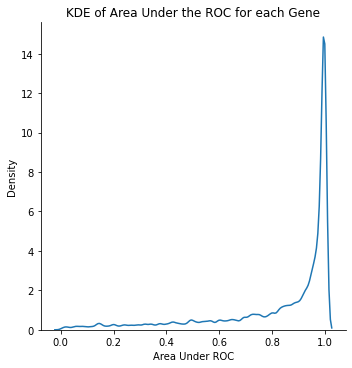

In [29]:
dupes_with_predicted_genes['Area Under ROC'] = (dupes_with_predicted_genes['Rank_of_True_Positve'] -1)/20878
dupes_with_predicted_genes['Inverse Area Under ROC'] = 1-dupes_with_predicted_genes['Area Under ROC']
sns.displot(dupes_with_predicted_genes,x = 'Area Under ROC', kind = 'kde',bw_adjust = .2)
plt.title("KDE of Area Under the ROC for each Gene")

Text(0.5, 1.0, 'Histogram of Area Under the ROC for each Gene')

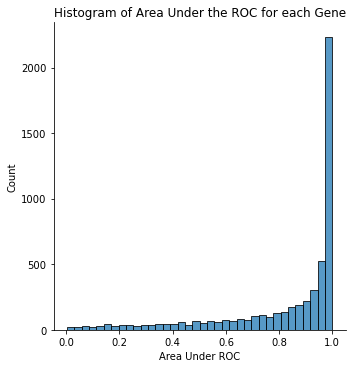

In [30]:
sns.displot(dupes_with_predicted_genes,x = 'Area Under ROC')
plt.title("Histogram of Area Under the ROC for each Gene")

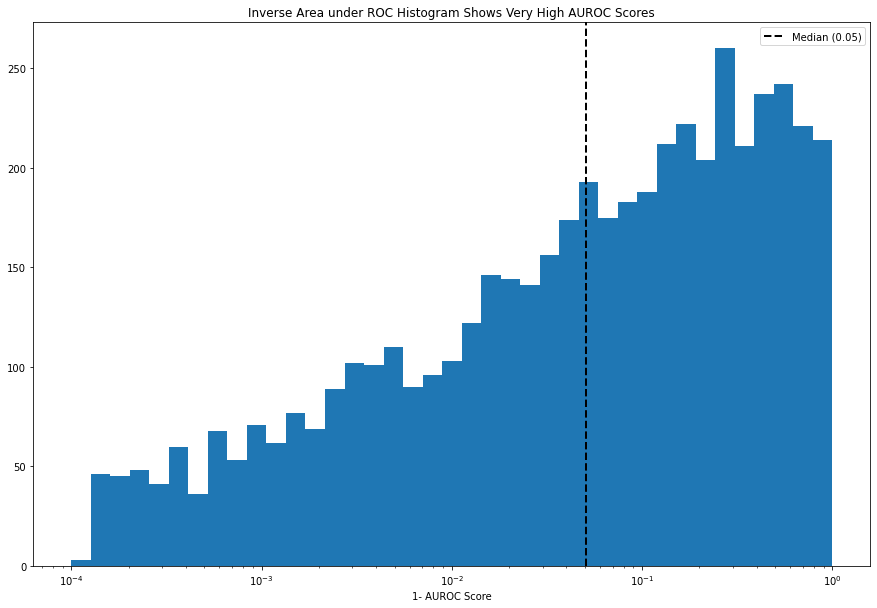

In [31]:
plt.close()

zed = dupes_with_predicted_genes['Area Under ROC']
zedprime = dupes_with_predicted_genes['Inverse Area Under ROC']
fig, ax = plt.subplots(figsize = (15,10))
plt.hist(zedprime,bins = np.logspace(np.log10(.0001),np.log10(1.0),40))
plt.gca().set_xscale('log')
#ax.xaxis.set_major_formatter((StrMethodFormatter('{x:,.3f}')))
plt.title('Inverse Area under ROC Histogram Shows Very High AUROC Scores')
plt.axvline(zedprime.median(),color = 'k',linestyle = 'dashed',linewidth = 2)
plt.legend(['Median (0.05)'])
plt.xlabel('1- AUROC Score')
plt.show()

In [32]:
zed

0       0.536689
1       0.252515
2       0.268728
3       0.987499
4       0.603243
          ...   
5393    0.049981
5394    0.955024
5395    0.595076
5396    0.974519
5397    0.021123
Name: Area Under ROC, Length: 5360, dtype: float64

In [33]:
zedprime.median()

0.05047178848548711

In [34]:
x = finger_prints_double_ranked.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_finger_prints = pd.DataFrame(x_scaled, columns = finger_prints_double_ranked.columns, index = finger_prints_double_ranked.index)
normalized_finger_prints


AT1G01020  AT1G01030  AT1G01040  AT1G01050  AT1G01060  AT1G01070  \
AT1G01020   0.001362   0.616518   0.784340   0.798869   0.080420   0.523504   
AT1G01060   0.452471   0.927536   0.785512   0.744987   0.876138   0.838855   
AT1G01110   0.464390   0.659372   0.680124   0.456401   0.293467   0.566167   
AT1G01130   0.703639   0.681927   0.279064   0.709563   0.637896   0.091040   
AT1G01160   0.957044   0.560131   0.754836   0.650463   0.047897   0.471214   
...              ...        ...        ...        ...        ...        ...   
ATCG00270   0.509194   0.847874   0.577911   0.406504   0.933231   0.242509   
ATCG00340   0.531913   0.867214   0.630056   0.416967   0.932465   0.192452   
ATCG00350   0.511457   0.863998   0.625000   0.391285   0.932656   0.184553   
ATCG01050   0.596565   0.903158   0.663980   0.447918   0.942427   0.136704   
ATCG01110   0.702131   0.931807   0.642145   0.386530   0.967334   0.077955   

           AT1G01080  AT1G01090  AT1G01100  AT1G01110  ...  ATCG01070  \
AT1G01020   0.299462   0.447326   0.822565   0.734880  ...   0.044657   
AT1G01060   0.800327   0.719413   0.515670   0.236006  ...   0.933062   
AT1G01110   0.589214   0.907115   0.724879   0.333269  ...   0.292477   
AT1G01130   0.834383   0.915133   0.911090   0.915988  ...   0.339578   
AT1G01160   0.098298   0.600976   0.627435   0.919390  ...   0.010398   
...              ...        ...        ...        ...  ...        ...   
ATCG00270   0.898962   0.805101   0.308221   0.584252  ...   0.998898   
ATCG00340   0.899587   0.809400   0.257811   0.621010  ...   0.998754   
ATCG00350   0.895164   0.802444   0.229074   0.605387  ...   0.998898   
ATCG01050   0.914151   0.812974   0.270419   0.647872  ...   0.999952   
ATCG01110   0.942343   0.846641   0.489947   0.670445  ...   0.999760   

           ATCG01080  ATCG01090  ATCG01100  ATCG01110  ATCG01120  ATCG01130  \
AT1G01020   0.161884   0.226640   0.232657   0.299743   0.455391   0.531803   
AT1G01060   0.921297   0.906802   0.927513   0.929561   0.899904   0.895509   
AT1G01110   0.584595   0.606485   0.534757   0.769663   0.613800   0.547572   
AT1G01130   0.755652   0.837107   0.595235   0.758039   0.918879   0.958779   
AT1G01160   0.060883   0.032665   0.123975   0.164005   0.177983   0.150985   
...              ...        ...        ...        ...        ...        ...   
ATCG00270   0.998371   0.998225   0.998514   0.999207   0.995256   0.995255   
ATCG00340   0.998419   0.998129   0.998658   0.999111   0.995017   0.995207   
ATCG00350   0.998371   0.997985   0.998658   0.999015   0.995256   0.995207   
ATCG01050   1.000000   0.998513   0.999808   1.000000   0.996167   0.996022   
ATCG01110   0.999569   1.000000   1.000000   0.974135   1.000000   1.000000   

           ATCG01180  ATCG01210  ATCG01310  
AT1G01020   0.003259   0.001246   0.066023  
AT1G01060   0.956286   0.961267   0.916486  
AT1G01110   0.242079   0.170797   0.484648  
AT1G01130   0.211451   0.097455   0.476767  
AT1G01160   0.064900   0.044677   0.135337  
...              ...        ...        ...  
ATCG00270   1.000000   1.000000   0.999087  
ATCG00340   0.999641   0.999712   0.999327  
ATCG00350   0.999712   0.999736   0.998991  
ATCG01050   0.997723   0.997867   0.998799  
ATCG01110   0.996213   0.996309   0.999640  

[5360 rows x 20879 columns]

In [35]:
### Take Values in each row, add to list. Then for each real match (5k of these) change value in list of zeros to 1, then append to 
iterator = range(5359)
list_of_model_score = []
list_of_true_values = []
for row in iterator:
    current_row = normalized_finger_prints.iloc[row].to_list()
    list_of_model_score.extend(current_row)
    current_true_values = [0]*20879
    current_gene_1 = normalized_finger_prints.iloc[row].name
    current_true_gene = dupes_with_predicted_genes['Gene 2'].loc[dupes_with_predicted_genes['Gene 1'] == current_gene_1].to_list()[0]
    index_of_true = normalized_finger_prints.columns.get_loc(current_true_gene)
    current_true_values[index_of_true] = 1 
    list_of_true_values.extend(current_true_values)
print(len(list_of_model_score))
print(len(list_of_true_values))



111890561
111890561


In [36]:
false_pos_rate,true_pos_rate, _ = metrics.roc_curve(list_of_true_values,list_of_model_score)

In [37]:
area_under_curve = metrics.roc_auc_score(list_of_true_values,list_of_model_score)
area_under_curve

0.8288136098892706

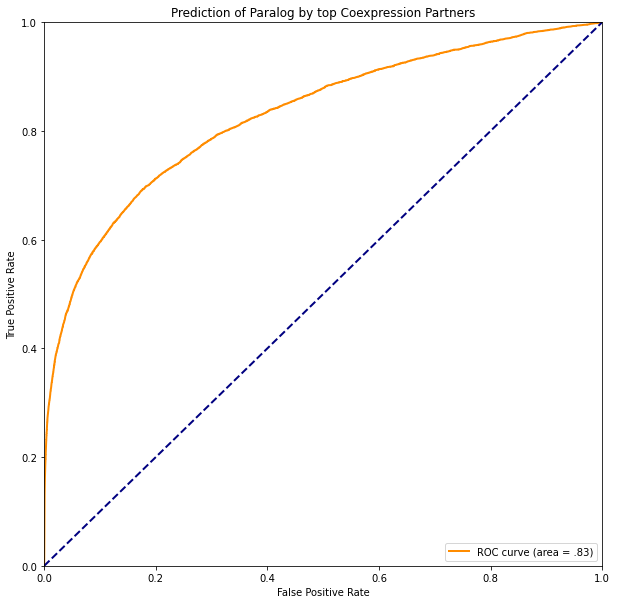

In [38]:
plt.figure(figsize = [10,10])
lw = 2
plt.plot(false_pos_rate,true_pos_rate,color ='darkorange',lw = lw, label = 'ROC curve (area = .83)')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Prediction of Paralog by top Coexpression Partners')
plt.show()

In [39]:
 dupes_with_predicted_genes['Gene 2'].loc[dupes_with_predicted_genes['Gene 1'] == 'AT1G01110'].to_list()[0]

'AT4G00820'

In [40]:
paralog_coexpression_pd = paired_genes_and_group_pd.copy()
paralog_coexpression_pd['Paralog Coexpression'] = np.diag(arabi_coconet.loc[paralog_coexpression_pd['Gene 1'].to_list(),paralog_coexpression_pd['Gene 2'].to_list()])
paralog_coexpression_pd['Gene 1 Average Coexpression'] = arabi_coconet.mean().loc[paralog_coexpression_pd['Gene 1'].to_list()].to_list()
paralog_coexpression_pd['Gene 2 Average Coexpression'] = arabi_coconet.mean().loc[paralog_coexpression_pd['Gene 2'].to_list()].to_list()
paralog_coexpression_pd['Difference Between Average Coexpression'] = abs(paralog_coexpression_pd['Gene 1 Average Coexpression'] - paralog_coexpression_pd['Gene 2 Average Coexpression'])
paralog_coexpression_pd

Group ID     Gene 1     Gene 2  Paralog Coexpression  \
0     100116at71240  AT2G17390  AT4G35450              0.932679   
1     121706at71240  AT2G01180  AT3G02600              0.560999   
2     122930at71240  AT1G78700  AT4G18890              0.687633   
3     122964at71240  AT1G20880  AT1G76460              0.992561   
4     123140at71240  AT3G02980  AT5G16800              0.659557   
...             ...        ...        ...                   ...   
2694   82324at71240  AT1G44130  AT1G77480              0.079753   
2695    8222at71240  AT5G09350  AT5G64070              0.990891   
2696    8234at71240  AT1G52570  AT3G15730              0.632551   
2697    8224at71240  AT1G04700  AT3G24715              0.794066   
2698   82839at71240  AT1G21400  AT5G09300              0.096230   

      Gene 1 Average Coexpression  Gene 2 Average Coexpression  \
0                        0.744475                     0.597789   
1                        0.459616                     0.705735   
2                        0.604137                     0.595828   
3                        0.570281                     0.577807   
4                        0.496022                     0.634235   
...                           ...                          ...   
2694                     0.173325                     0.661581   
2695                     0.647424                     0.688407   
2696                     0.497181                     0.688086   
2697                     0.535964                     0.472389   
2698                     0.327684                     0.565103   

      Difference Between Average Coexpression  
0                                    0.146686  
1                                    0.246118  
2                                    0.008309  
3                                    0.007526  
4                                    0.138213  
...                                       ...  
2694                                 0.488256  
2695                                 0.040984  
2696                                 0.190905  
2697                                 0.063575  
2698                                 0.237420  

[2699 rows x 7 columns]

In [41]:
melted_paralog = paralog_coexpression_pd.melt(id_vars = ['Paralog Coexpression'],value_vars = ['Gene 1 Average Coexpression','Gene 2 Average Coexpression'])
melted_paralog.columns = ['Paralog Coexpression','Gene in Pair','Average Coexpression']
melted_paralog.loc[melted_paralog['Paralog Coexpression'] == 0.932678567346191]

Paralog Coexpression                 Gene in Pair  Average Coexpression
0                 0.932679  Gene 1 Average Coexpression              0.744475
2699              0.932679  Gene 2 Average Coexpression              0.597789

In [42]:
melted_paralog

Paralog Coexpression                 Gene in Pair  Average Coexpression
0                 0.932679  Gene 1 Average Coexpression              0.744475
1                 0.560999  Gene 1 Average Coexpression              0.459616
2                 0.687633  Gene 1 Average Coexpression              0.604137
3                 0.992561  Gene 1 Average Coexpression              0.570281
4                 0.659557  Gene 1 Average Coexpression              0.496022
...                    ...                          ...                   ...
5393              0.079753  Gene 2 Average Coexpression              0.661581
5394              0.990891  Gene 2 Average Coexpression              0.688407
5395              0.632551  Gene 2 Average Coexpression              0.688086
5396              0.794066  Gene 2 Average Coexpression              0.472389
5397              0.096230  Gene 2 Average Coexpression              0.565103

[5398 rows x 3 columns]

Text(0.5, 1.0, 'Correlation of Coexpression between Paralog Genes and Their Average Coexpression with all Genes')

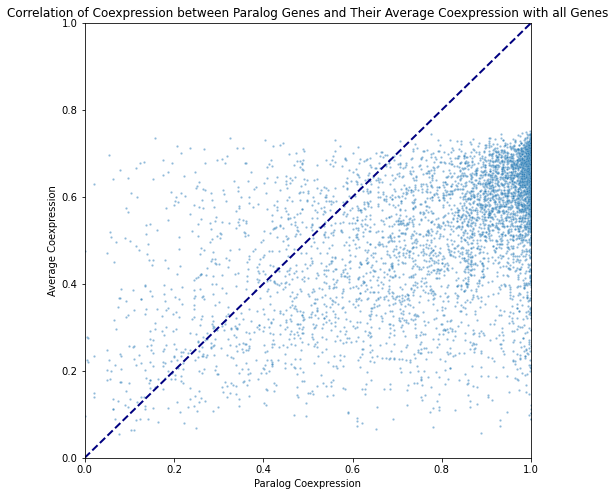

In [43]:
plt.figure(figsize = (8,8))
sns.scatterplot(data = melted_paralog, x = 'Paralog Coexpression',y = 'Average Coexpression',alpha = .5, s = 5)
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.title("Correlation of Coexpression between Paralog Genes and Their Average Coexpression with all Genes")

Text(0.5, 1.0, 'Correlation of Coexpression between Paralog Genes and Their Average Coexpression with all Genes')

<Figure size 864x864 with 0 Axes>

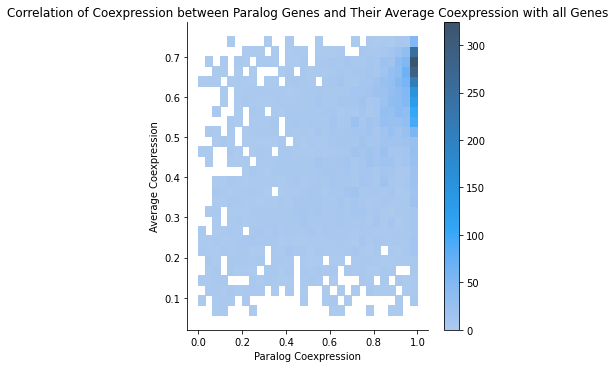

In [44]:
plt.figure(figsize = (12,12))
sns.displot(data = melted_paralog, x = 'Paralog Coexpression',y = 'Average Coexpression',cbar = True)
plt.title("Correlation of Coexpression between Paralog Genes and Their Average Coexpression with all Genes")

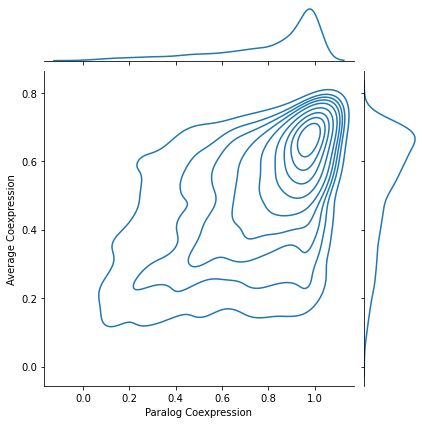

In [45]:
sns.jointplot(data = melted_paralog, x = 'Paralog Coexpression',y = 'Average Coexpression',kind = 'kde')
#plt.title("Correlation of Coexpression between Paralog Genes and Their Average Coexpression with all Genes")

Text(1.0, 1.0, 'Correlation of Coexpression between Paralog Genes and Their Average Coexpression with all Genes')

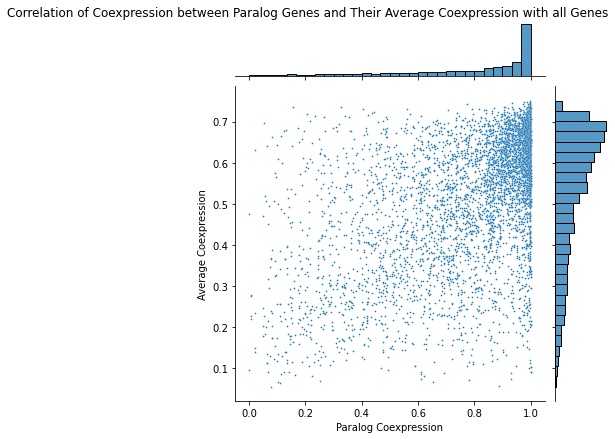

In [46]:
sns.jointplot(data = melted_paralog, x = 'Paralog Coexpression',y = 'Average Coexpression',s = 3)
plt.title("Correlation of Coexpression between Paralog Genes and Their Average Coexpression with all Genes",pad = 70,loc = 'right')

<AxesSubplot:xlabel='Paralog Coexpression', ylabel='Average Coexpression'>

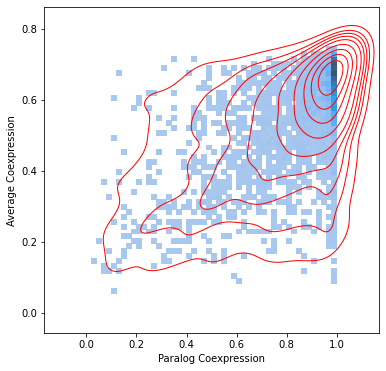

In [47]:
f, ax = plt.subplots(figsize=(6, 6))
#sns.scatterplot(data = melted_paralog, x = 'Paralog Coexpression',y = 'Average Coexpression', s = 5)
sns.histplot(data = melted_paralog, x = 'Paralog Coexpression',y = 'Average Coexpression', bins=50, pthresh=.01,)
sns.kdeplot(data = melted_paralog, x = 'Paralog Coexpression',y = 'Average Coexpression', color="r", linewidths=1)

Text(0.5, 1.0, 'Genes with High paralog coexpresion tend to both have similar average Coexpression')

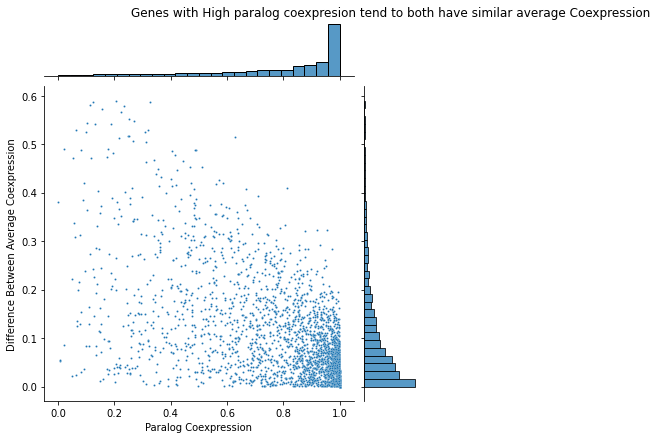

In [48]:
sns.jointplot(data = paralog_coexpression_pd, x = 'Paralog Coexpression',y = 'Difference Between Average Coexpression',s = 4)
plt.title('Genes with High paralog coexpresion tend to both have similar average Coexpression', pad = 70)

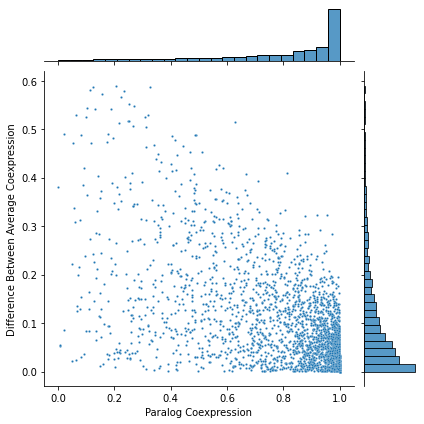

In [49]:
sns.jointplot(data = paralog_coexpression_pd, x = 'Paralog Coexpression',y = 'Difference Between Average Coexpression',s = 5)

In [50]:
### redoing above but with just coexpression as metrick
coexpress_fixed_rank = arabi_coconet.replace(to_replace = 1, value = .001)
coexpress_double_ranked = coexpress_fixed_rank.rank(axis = 1)
coexpress_double_ranked = coexpress_double_ranked.loc[coexpress_double_ranked.index.isin(list_of_reference_genes_to_get_top10_from)]
top_pair_for_each_reference_coexp = coexpress_double_ranked.idxmax(axis = 'columns')
top_pair_for_each_reference_coexp = top_pair_for_each_reference_coexp.to_frame(name = 'Predicted Gene')
top_pair_for_each_reference_coexp.reset_index(inplace = True)

In [51]:
long_form_gene_duplications_coexp = paired_genes_and_group_pd.copy()
gene_2_list_coexp = long_form_gene_duplications_coexp['Gene 2'].to_list()
gene_1_list_coexp = long_form_gene_duplications_coexp['Gene 1'].to_list()
gene_groups_coexp = long_form_gene_duplications_coexp['Group ID'].to_list()
doubled_up_coexp = pd.DataFrame(list(zip(gene_groups_coexp,gene_2_list_coexp,gene_1_list_coexp)),columns = ['Group ID','Gene 1','Gene 2'])
long_form_gene_duplications_coexp = pd.concat([long_form_gene_duplications_coexp,doubled_up_coexp],ignore_index = True)
long_form_gene_duplications_coexp

Group ID     Gene 1     Gene 2
0     100116at71240  AT2G17390  AT4G35450
1     121706at71240  AT2G01180  AT3G02600
2     122930at71240  AT1G78700  AT4G18890
3     122964at71240  AT1G20880  AT1G76460
4     123140at71240  AT3G02980  AT5G16800
...             ...        ...        ...
5393   82324at71240  AT1G77480  AT1G44130
5394    8222at71240  AT5G64070  AT5G09350
5395    8234at71240  AT3G15730  AT1G52570
5396    8224at71240  AT3G24715  AT1G04700
5397   82839at71240  AT5G09300  AT1G21400

[5398 rows x 3 columns]

In [52]:
top_pair_for_each_reference_coexp.rename(columns = {'index':'Gene 1'},inplace = True)
dupes_with_predicted_genes_coexp = long_form_gene_duplications_coexp.merge(top_pair_for_each_reference_coexp,on = 'Gene 1',how = 'left')
dupes_with_predicted_genes_coexp.dropna(subset = ['Predicted Gene'],inplace = True)
dupes_with_predicted_genes_coexp.drop_duplicates(inplace = True)
dupes_with_predicted_genes_coexp


Group ID     Gene 1     Gene 2 Predicted Gene
0     100116at71240  AT2G17390  AT4G35450      AT1G47420
1     121706at71240  AT2G01180  AT3G02600      AT3G11820
2     122930at71240  AT1G78700  AT4G18890      AT3G17850
3     122964at71240  AT1G20880  AT1G76460      AT1G48790
4     123140at71240  AT3G02980  AT5G16800      AT5G10745
...             ...        ...        ...            ...
5393   82324at71240  AT1G77480  AT1G44130      AT1G72650
5394    8222at71240  AT5G64070  AT5G09350      AT4G00800
5395    8234at71240  AT3G15730  AT1G52570      AT5G39570
5396    8224at71240  AT3G24715  AT1G04700      AT5G06970
5397   82839at71240  AT5G09300  AT1G21400      AT4G26760

[5360 rows x 4 columns]

In [53]:
rank_of_correct_gene_prediction_coexp = []
for gene_pair_coexp in dupes_with_predicted_genes_coexp.iterrows():
    current_correct_gene_prediction_coexp = coexpress_double_ranked.loc[gene_pair_coexp[1][1],gene_pair_coexp[1][2]]
    rank_of_correct_gene_prediction_coexp.append(current_correct_gene_prediction_coexp)
dupes_with_predicted_genes_coexp['Rank_of_True_Positve'] = rank_of_correct_gene_prediction_coexp   
dupes_with_predicted_genes_coexp.mean()
    

Rank_of_True_Positve    17332.555597
dtype: float64

In [54]:
dupes_with_predicted_genes_coexp['Area Under ROC'] = (dupes_with_predicted_genes_coexp['Rank_of_True_Positve'] -1)/20878

In [55]:
dupes_with_predicted_genes_coexp

Group ID     Gene 1     Gene 2 Predicted Gene  \
0     100116at71240  AT2G17390  AT4G35450      AT1G47420   
1     121706at71240  AT2G01180  AT3G02600      AT3G11820   
2     122930at71240  AT1G78700  AT4G18890      AT3G17850   
3     122964at71240  AT1G20880  AT1G76460      AT1G48790   
4     123140at71240  AT3G02980  AT5G16800      AT5G10745   
...             ...        ...        ...            ...   
5393   82324at71240  AT1G77480  AT1G44130      AT1G72650   
5394    8222at71240  AT5G64070  AT5G09350      AT4G00800   
5395    8234at71240  AT3G15730  AT1G52570      AT5G39570   
5396    8224at71240  AT3G24715  AT1G04700      AT5G06970   
5397   82839at71240  AT5G09300  AT1G21400      AT4G26760   

      Rank_of_True_Positve  Area Under ROC  
0                  14212.0        0.680669  
1                  13642.0        0.653367  
2                  11695.0        0.560111  
3                  20812.0        0.996791  
4                  14722.0        0.705096  
...                    ...             ...  
5393                 460.0        0.021985  
5394               19420.0        0.930118  
5395                7639.0        0.365840  
5396               19491.0        0.933519  
5397                 974.0        0.046604  

[5360 rows x 6 columns]

Text(0.5, 1.0, 'Histogram of Area Under the ROC for each Gene')

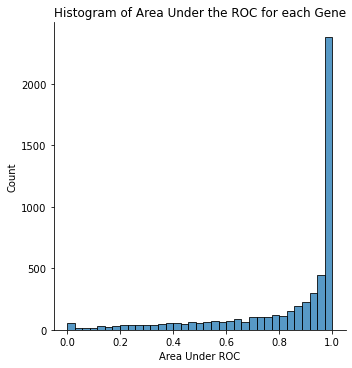

In [56]:
sns.displot(dupes_with_predicted_genes_coexp,x = 'Area Under ROC')
plt.title("Histogram of Area Under the ROC for each Gene")

In [57]:
x_coexp = coexpress_double_ranked.values
min_max_scaler_coexp = preprocessing.MinMaxScaler()
x_scaled_coexp = min_max_scaler_coexp.fit_transform(x_coexp)
normalized_coexpress_double_ranked = pd.DataFrame(x_scaled_coexp, columns = coexpress_double_ranked.columns, index = coexpress_double_ranked.index)
normalized_coexpress_double_ranked

AT1G01020  AT1G01030  AT1G01040  AT1G01050  AT1G01060  AT1G01070  \
AT1G01020   0.000000   0.417068   0.713748   0.789844   0.050771   0.355459   
AT1G01060   0.499424   0.915791   0.951379   0.953048   0.009196   0.813275   
AT1G01110   0.822077   0.572369   0.652360   0.593497   0.060925   0.360361   
AT1G01130   0.747142   0.382529   0.363885   0.988639   0.246336   0.195451   
AT1G01160   0.843981   0.278275   0.755700   0.661227   0.038030   0.398157   
...              ...        ...        ...        ...        ...        ...   
ATCG00270   0.811653   0.845632   0.739968   0.527274   0.639908   0.213393   
ATCG00340   0.663128   0.820281   0.811731   0.671019   0.665868   0.273102   
ATCG00350   0.770007   0.886853   0.827576   0.665558   0.683111   0.242757   
ATCG01050   0.857047   0.965167   0.883721   0.520495   0.335712   0.188048   
ATCG01110   0.931502   0.923553   0.865595   0.765489   0.675160   0.179077   

           AT1G01080  AT1G01090  AT1G01100  AT1G01110  ...  ATCG01070  \
AT1G01020   0.588292   0.713824   0.942059   0.464392  ...   0.027663   
AT1G01060   0.674664   0.784416   0.617557   0.251366  ...   0.266564   
AT1G01110   0.505470   0.937605   0.790265   0.002109  ...   0.033608   
AT1G01130   0.792226   0.981918   0.944339   0.678424  ...   0.027519   
AT1G01160   0.373177   0.725204   0.746882   0.586936  ...   0.001774   
...              ...        ...        ...        ...  ...        ...   
ATCG00270   0.895058   0.912436   0.300141   0.232963  ...   0.999137   
ATCG00340   0.957150   0.932253   0.222837   0.454807  ...   0.999425   
ATCG00350   0.946497   0.927142   0.203572   0.508866  ...   0.999425   
ATCG01050   0.976440   0.944067   0.299364   0.593358  ...   1.000000   
ATCG01110   0.960701   0.976662   0.549571   0.570258  ...   0.999521   

           ATCG01080  ATCG01090  ATCG01100  ATCG01110  ATCG01120  ATCG01130  \
AT1G01020   0.065824   0.103921   0.127200   0.143200   0.119704   0.312911   
AT1G01060   0.386605   0.326766   0.552045   0.569203   0.386492   0.611332   
AT1G01110   0.095765   0.096156   0.095555   0.122010   0.110193   0.173631   
AT1G01130   0.115982   0.121896   0.087261   0.131886   0.124171   0.436549   
AT1G01160   0.014851   0.016202   0.023062   0.024018   0.027188   0.049177   
...              ...        ...        ...        ...        ...        ...   
ATCG00270   0.998994   0.998610   0.999377   0.999185   0.997454   0.997361   
ATCG00340   0.998994   0.998754   0.999089   0.999233   0.996878   0.996738   
ATCG00350   0.999042   0.998418   0.999089   0.999089   0.997022   0.996977   
ATCG01050   1.000000   0.999281   1.000000   1.000000   0.998031   0.998897   
ATCG01110   0.999952   1.000000   1.000000   0.000000   1.000000   1.000000   

           ATCG01180  ATCG01210  ATCG01310  
AT1G01020   0.001870   0.001199   0.020410  
AT1G01060   0.205763   0.192765   0.153486  
AT1G01110   0.017882   0.019862   0.042943  
AT1G01130   0.010116   0.005805   0.025042  
AT1G01160   0.003548   0.002063   0.009843  
...              ...        ...        ...  
ATCG00270   0.997555   0.997553   0.995030  
ATCG00340   0.998610   0.998465   0.996092  
ATCG00350   0.998801   0.999040   0.996429  
ATCG01050   0.996836   0.997361   1.000000  
ATCG01110   0.996740   0.996786   0.999421  

[5360 rows x 20879 columns]

In [58]:
iterator = range(5359)
model_coexpress = []
true_values_coexpress = []
for row in iterator:
    current_row = normalized_coexpress_double_ranked.iloc[row].to_list()
    model_coexpress.extend(current_row)
    current_true_values = [0]*20879
    current_gene_1 = normalized_coexpress_double_ranked.iloc[row].name
    current_true_gene = dupes_with_predicted_genes_coexp['Gene 2'].loc[dupes_with_predicted_genes_coexp['Gene 1'] == current_gene_1].to_list()[0]
    index_of_true = normalized_coexpress_double_ranked.columns.get_loc(current_true_gene)
    current_true_values[index_of_true] = 1 
    true_values_coexpress.extend(current_true_values)
print(len(model_coexpress))
print(len(true_values_coexpress))


111890561
111890561


In [59]:
false_pos_rate,true_pos_rate, _ = metrics.roc_curve(true_values_coexpress,model_coexpress)

In [60]:
list_of_model_score[0:5]

[0.0013621327106440942,
 0.6165178999904021,
 0.7843395857756936,
 0.7988688946015424,
 0.08041958041958042]

In [61]:
area_under_curve = metrics.roc_auc_score(true_values_coexpress,model_coexpress)
area_under_curve

0.8356358660853624

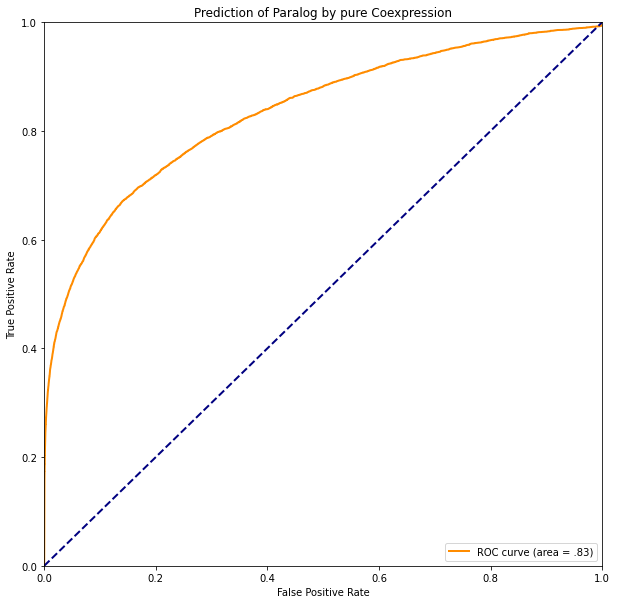

In [62]:
plt.figure(figsize = [10,10])
lw = 2
plt.plot(false_pos_rate,true_pos_rate,color ='darkorange',lw = lw, label = 'ROC curve (area = .83)')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Prediction of Paralog by pure Coexpression')
plt.show()

In [63]:
### Tmrrw- log scale histogram

In [64]:
## Start by taking long versions of the two other gene sets 
all_target_genes_long = []
reference_genes_long = [] 
num_reference_genes = range(5359)
for row_number in num_reference_genes:
    all_target_genes_long.extend(normalized_finger_prints.columns.to_list())
    current_gene = normalized_finger_prints.iloc[row_number].name 
    reference_genes_long.extend([current_gene]*20879)
    


In [65]:
len(all_target_genes_long)

111890561

In [66]:
len(reference_genes_long)

111890561

In [67]:
analyzing_top_matches = pd.DataFrame(data = list(zip(reference_genes_long,all_target_genes_long,list_of_model_score,list_of_true_values)),columns = ['Reference Gene','Target Gene','Model Score','True Value'])
analyzing_top_matches

Reference Gene Target Gene  Model Score  True Value
0              AT1G01020   AT1G01020     0.001362           0
1              AT1G01020   AT1G01030     0.616518           0
2              AT1G01020   AT1G01040     0.784340           0
3              AT1G01020   AT1G01050     0.798869           0
4              AT1G01020   AT1G01060     0.080420           0
...                  ...         ...          ...         ...
111890556      ATCG01050   ATCG01120     0.996167           0
111890557      ATCG01050   ATCG01130     0.996022           0
111890558      ATCG01050   ATCG01180     0.997723           0
111890559      ATCG01050   ATCG01210     0.997867           0
111890560      ATCG01050   ATCG01310     0.998799           0

[111890561 rows x 4 columns]

In [68]:
analyzing_top_matches = analyzing_top_matches.loc[analyzing_top_matches['True Value'] == 1] 
analyzing_top_matches = analyzing_top_matches.sort_values(by = 'Model Score',ascending = False)
top_10percent = analyzing_top_matches[0:int(5359*.1)]
second_best = analyzing_top_matches[0:int(5359*.2)]
worst = analyzing_top_matches[int(5359*.1):5359]


In [69]:
gene_set_1 = top_10percent['Reference Gene'].to_list()
gene_set_2 = second_best['Reference Gene'].to_list()
gene_set_3 = worst['Reference Gene'].to_list()


In [70]:
arab_go = h5py.File('/home/passala/Gene_duplication_project/Networks/arabidopsis_gene2go.hdf5','r')
Go_dataset = arab_go['GO']
genes_dataset = arab_go['genes'] 
Go_groups = []
for annot in Go_dataset:
    current_annot = annot.decode('UTF-8')
    Go_groups.append(current_annot)
Gene_groups = []
for genename in genes_dataset:
    cur_gene_name = genename.decode('UTF-8')
    Gene_groups.append(cur_gene_name)
arab_go_matrix = scipy.io.mmread('/home/passala/Gene_duplication_project/Networks/arab_sparse_matrix_full.mtx')
d_arab_go = arab_go_matrix.todense()
panda_arab = pd.DataFrame.sparse.from_spmatrix(data = arab_go_matrix, index = Gene_groups , columns = Go_groups)
panda_arab = panda_arab.drop(index = 'NA')

In [71]:
panda_arab = panda_arab[panda_arab.columns[panda_arab.sum()<=1000]]
panda_arab = panda_arab[panda_arab.columns[panda_arab.sum()>=8]]

In [72]:
go_arab_annotation = panda_arab

In [73]:
go_arab_annotation

GO:0000014  GO:0000018  GO:0000027  GO:0000028  GO:0000030  \
AT2G01050         0.0         0.0         0.0         0.0         0.0   
AT2G01060         0.0         0.0         0.0         0.0         0.0   
AT2G01080         0.0         0.0         0.0         0.0         0.0   
AT2G01070         0.0         0.0         0.0         0.0         0.0   
AT2G01090         0.0         0.0         0.0         0.0         0.0   
...               ...         ...         ...         ...         ...   
ATCG00160         0.0         0.0         0.0         0.0         0.0   
AT1G53903         0.0         0.0         0.0         0.0         0.0   
AT1G05250         0.0         0.0         0.0         0.0         0.0   
AT5G35715         0.0         0.0         0.0         0.0         0.0   
AT1G58983         0.0         0.0         0.0         0.0         0.0   

           GO:0000036  GO:0000038  GO:0000041  GO:0000045  GO:0000049  ...  \
AT2G01050         0.0         0.0         0.0         0.0         0.0  ...   
AT2G01060         0.0         0.0         0.0         0.0         0.0  ...   
AT2G01080         0.0         0.0         0.0         0.0         0.0  ...   
AT2G01070         0.0         0.0         0.0         0.0         0.0  ...   
AT2G01090         0.0         0.0         0.0         0.0         0.0  ...   
...               ...         ...         ...         ...         ...  ...   
ATCG00160         0.0         0.0         0.0         0.0         0.0  ...   
AT1G53903         0.0         0.0         0.0         0.0         0.0  ...   
AT1G05250         0.0         0.0         0.0         0.0         0.0  ...   
AT5G35715         0.0         0.0         0.0         0.0         0.0  ...   
AT1G58983         0.0         0.0         0.0         0.0         0.0  ...   

           GO:2001006  GO:2001020  GO:2001022  GO:2001023  GO:2001038  \
AT2G01050         0.0         0.0         0.0         0.0         0.0   
AT2G01060         0.0         0.0         0.0         0.0         0.0   
AT2G01080         0.0         0.0         0.0         0.0         0.0   
AT2G01070         0.0         0.0         0.0         0.0         0.0   
AT2G01090         0.0         0.0         0.0         0.0         0.0   
...               ...         ...         ...         ...         ...   
ATCG00160         0.0         0.0         0.0         0.0         0.0   
AT1G53903         0.0         0.0         0.0         0.0         0.0   
AT1G05250         0.0         0.0         0.0         0.0         0.0   
AT5G35715         0.0         0.0         0.0         0.0         0.0   
AT1G58983         0.0         0.0         0.0         0.0         0.0   

           GO:2001057  GO:2001070  GO:2001251  GO:2001252  GO:2001289  
AT2G01050         0.0         0.0         0.0         0.0         0.0  
AT2G01060         0.0         0.0         0.0         0.0         0.0  
AT2G01080         0.0         0.0         0.0         0.0         0.0  
AT2G01070         0.0         0.0         0.0         0.0         0.0  
AT2G01090         0.0         0.0         0.0         0.0         0.0  
...               ...         ...         ...         ...         ...  
ATCG00160         0.0         0.0         0.0         0.0         0.0  
AT1G53903         0.0         0.0         0.0         0.0         0.0  
AT1G05250         0.0         0.0         0.0         0.0         0.0  
AT5G35715         0.0         0.0         0.0         0.0         0.0  
AT1G58983         0.0         0.0         0.0         0.0         0.0  

[27560 rows x 4471 columns]

In [74]:
background_distribution_num_genes_annotated = go_arab_annotation.sum(axis = 0)
background_distribution_num_genes_unnannotated = go_arab_annotation.shape[0] - background_distribution_num_genes_annotated
list_of_genes_for_go = gene_set_3
go_duplicated_subset = go_arab_annotation.loc[list_of_genes_for_go]
go_subset_distribution_num_annotated_genes = go_duplicated_subset.sum(axis = 0)
go_subset_distribution_num_unnannotated_genes = go_duplicated_subset.shape[0] - go_subset_distribution_num_annotated_genes
go_subset_distribution_num_annotated_genes

list_of_go_contingency_tables = []
i = 0 
for go_term in background_distribution_num_genes_annotated:
    contingency_table = [[(go_term-go_subset_distribution_num_annotated_genes[i]),go_subset_distribution_num_annotated_genes[i]],[(background_distribution_num_genes_unnannotated[i]-go_subset_distribution_num_unnannotated_genes[i]),go_subset_distribution_num_unnannotated_genes[i]]]
    list_of_go_contingency_tables.append(contingency_table)
    i += 1 

    

In [75]:
list_of_go_contingency_tables[0]

[[11.0, 0.0], [22725.0, 4824.0]]

In [76]:
list_of_p_values_go_change = []
for table in list_of_go_contingency_tables:
    odds, p_value = stats.fisher_exact(table = table, alternative = 'less')
    list_of_p_values_go_change.append(p_value)

In [77]:
rejected, corrected_pvalues = multitest.fdrcorrection(pvals = list_of_p_values_go_change, alpha = .05)
corrected_pvalues = corrected_pvalues.tolist()
go_enrichment_results = pd.DataFrame(corrected_pvalues,index = go_arab_annotation.columns.to_list(),columns=['P_value'])

In [78]:
go_enrichment_results = go_enrichment_results.sort_values('P_value')

<AxesSubplot:ylabel='Count'>

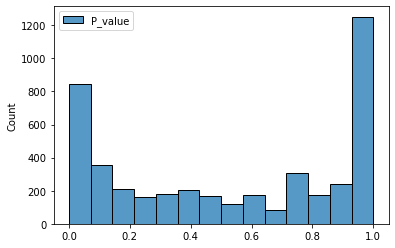

In [79]:
sns.histplot(go_enrichment_results,)

In [80]:
np.savetxt('/home/passala/Gene_duplication_project/Generated_tables/gene_list_1.csv',delimiter = ',',fmt = '% s',X = gene_set_1)

In [81]:
go_names = pd.read_csv(filepath_or_buffer = '/home/passala/Gene_duplication_project/Data_from_others/go_terms.txt', sep = '\t')

In [82]:
go_names.head(5)

Name
GO:0000001                          mitochondrion inheritance
GO:0000002                   mitochondrial genome maintenance
GO:0000003                                       reproduction
GO:0000006  high-affinity zinc transmembrane transporter a...
GO:0000007  low-affinity zinc ion transmembrane transporte...

In [83]:
full_go_results = go_enrichment_results.join(other = go_names, how = 'left')
full_go_results.loc['GO:0044212','Name'] = 'transcription cis-regulatory region binding'


In [84]:
full_go_results.head(20)

P_value                                               Name
GO:0051641  3.122886e-10                              cellular localization
GO:0005789  4.095994e-09                     endoplasmic reticulum membrane
GO:0008104  4.095994e-09                               protein localization
GO:0070727  4.805745e-09                cellular macromolecule localization
GO:0042175  4.805745e-09  nuclear outer membrane-endoplasmic reticulum m...
GO:0015833  5.200621e-09                                  peptide transport
GO:0015031  5.473044e-09                                  protein transport
GO:0045184  8.741588e-09              establishment of protein localization
GO:0042886  8.741588e-09                                    amide transport
GO:0005623  2.070575e-08                                                NaN
GO:0046907  5.773998e-08                            intracellular transport
GO:0034613  8.362489e-08                      cellular protein localization
GO:0031300  1.046831e-07          intrinsic component of organelle membrane
GO:0019637  2.627351e-07                  organophosphate metabolic process
GO:0008509  4.818448e-07           anion transmembrane transporter activity
GO:0097708  6.658294e-07                              intracellular vesicle
GO:0031410  9.342171e-07                                cytoplasmic vesicle
GO:0031301  1.234467e-06           integral component of organelle membrane
GO:0098656  1.234467e-06                      anion transmembrane transport
GO:0033365  1.862280e-06                  protein localization to organelle

In [85]:
import plotly.graph_objects as go 

fig = go.Figure(data = [go.Table(header = dict(values = ['Go Accession','P Value','Name'], fill_color = 'skyblue',align = 'left'),cells = dict(values =[full_go_results.head(20).index,full_go_results.head(20).P_value,full_go_results.head(20).Name],fill_color ='white',align = 'left'))])
fig.show()
#fig.write_image('/home/passala/Gene_duplication_project/Figures/Other Figures/newplot2.jpeg', width = 1500,height = 700,scale = 4)